# HackLive 4: Stock Price Prediction

#### Summary: 
To understand the changes in the past, moving averages and standard deviations were calculated for short, medium and long timesteps. After adding the the moving featuresto the dataset, a deep neural network with three hidden layers is trained. The predictions were done iteratively.After each prediction of a time point, the moving averages and standard deviations of the next time point were determined using the last prediction result.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import Dense

ss = pd.read_csv('SampleSubmission_ZxsCq0O.csv')
train = pd.read_csv('Train_awoL0xl.csv')
test = pd.read_csv('Test_QQKW4dv.csv')

Using TensorFlow backend.


In [3]:
train.head(3)

,ID,stock,Date,Open,High,Low,Close,holiday,unpredictability_score
0,id_0,0,2017-01-03,82.9961,82.7396,82.9144,82.8101,1,7
1,id_1,0,2017-01-04,83.1312,83.1669,83.3779,82.9690,0,7
2,id_2,0,2017-01-05,82.6622,82.7634,82.8984,82.8578,0,7


In [4]:
test.head(3)

,ID,stock,Date,holiday,unpredictability_score
0,id_713,0,2019-11-01,0,7
1,id_714,0,2019-11-04,0,7
2,id_715,0,2019-11-05,0,7


The test data doesn't include the "Open", "High", and the "Low" features. So, there's no point using these features 

In [5]:
del train['Open'], train['High'], train['Low']

We can extract temporal features from the "Date" column

In [6]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df['Date'] = pd.to_datetime(df["Date"])
for attr in ['year', 'month', 'day', 'week', 'dayofweek']:
  df[attr] = getattr(df['Date'].dt, attr)

features = ['stock', 'holiday', 'unpredictability_score', 'year', 'month', 'day', 'week', 'dayofweek', 'Close']  
train, test = df[:train.shape[0]].reset_index(drop = True), df[train.shape[0]:].reset_index(drop = True)

C:\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


And this is how the data looks like:

In [7]:
train[features].head(3)

,stock,holiday,unpredictability_score,year,month,day,week,dayofweek,Close
0,0,1,7,2017,1,3,1,1,82.8101
1,0,0,7,2017,1,4,1,2,82.9690
2,0,0,7,2017,1,5,1,3,82.8578


So obviously, stock prices can not be predicted given only the holiday and date features. The samples are dependent to the previous ones, an important property of time-series data. We need to know what the average stock prices were in the previous timepoints and how they varied. For this purpose I added 4 timesteps (nsteps_1,nsteps_2,...), each longer than the previous step. Each timestep will be used for calculating the moving average and standard devition of the last "nstep" days.

In [8]:
nsteps_1=10  
nsteps_2=30 
nsteps_3=75
nsteps_4=150  
nsteps_5=300

But we must calculate the moving features (average and standard devition) for the same stocks. Therefore, we seperate the train data for each stock, then apply do the calculations. The naming I used for the columns are given below:

MA10: The rolling mean of the past nsteps_1=10 days 

MA75: The rolling mean of the past nsteps_2=75 days

...

ss10: The rolling standard devition of the past nsteps_1=10 days 

ss75: The rolling standard devition of the past nsteps_2=75 days

...

In [9]:
for i in range(0,103):
    no="stock%d" %(i)
    condition = train["stock"] == i
    exec('{} = train[condition].reset_index(drop=True)'.format(no))
    no=eval(no)
    no['MA%d' %(nsteps_1)] = no.loc[:,'Close'].rolling(window=nsteps_1).mean()  # MA10
    no['MA%d' %(nsteps_2)] = no.loc[:,'Close'].rolling(window=nsteps_2).mean()  # MA30
    no['MA%d' %(nsteps_3)] = no.loc[:,'Close'].rolling(window=nsteps_3).mean()  # MA75
    no['MA%d' %(nsteps_4)] = no.loc[:,'Close'].rolling(window=nsteps_4).mean()  # MA150
    no['MA%d' %(nsteps_5)] = no.loc[:,'Close'].rolling(window=nsteps_5).mean()  # MA300
    
    no['ss%d' %(nsteps_1)] = no.loc[:,'Close'].rolling(window=nsteps_1).std()  # ss10
    no['ss%d' %(nsteps_2)] = no.loc[:,'Close'].rolling(window=nsteps_2).std()  # ss30
    no['ss%d' %(nsteps_3)] = no.loc[:,'Close'].rolling(window=nsteps_3).std()  # ss75
    no['ss%d' %(nsteps_4)] = no.loc[:,'Close'].rolling(window=nsteps_4).std()  # ss150
    no['ss%d' %(nsteps_5)] = no.loc[:,'Close'].rolling(window=nsteps_5).std()  # ss300

    no=no.iloc[nsteps_5:,:]  #delete the nan values
    exec('{} = no.reset_index(drop=True)'.format("stock%d" %(i)))
    del no

Let's see what the new train data (newtr) looks like:

In [10]:
# %% concat train stock data 
newtr=pd.DataFrame(stock0)
for i in range(1,103):
    no="stock%d" %(i)
    no=eval(no) 
    newtr=pd.concat([newtr, no], axis=0)  
    
newtr.head(3)    

,ID,stock,Date,Close,holiday,unpredictability_score,year,month,day,week,...,MA10,MA30,MA75,MA150,MA300,ss10,ss30,ss75,ss150,ss300
0,id_300,0,2018-03-14,92.3212,0,7,2018,3,14,11,...,90.96202,91.227050,94.288067,92.971540,91.104018,1.597689,2.560643,3.148419,2.969216,4.035294
1,id_301,0,2018-03-15,91.8108,0,7,2018,3,15,11,...,91.28061,91.023233,94.263183,92.959533,91.133491,1.383104,2.231266,3.160665,2.970251,4.007875
2,id_302,0,2018-03-16,91.5226,0,7,2018,3,16,11,...,91.49465,90.809810,94.234997,92.946949,91.162373,1.211668,1.815852,3.175718,2.972327,3.979156


After rearrenging the train data, we divide the last 40 to use it for validation

In [11]:
# %%Validation data
LAST_TRAINING_DAY = train['Date'].max()
DAYS_TO_VALIDATE = pd.Timedelta(days = 40)
VAL_FIRST_DAY = LAST_TRAINING_DAY - DAYS_TO_VALIDATE
LAST_TRAINING_DAY - VAL_FIRST_DAY

val_fltr = newtr['Date'] >= VAL_FIRST_DAY
val = newtr[val_fltr].reset_index(drop = True)

Now let's define our features and the model. I used a deep neural network with 3 hidden layers

In [12]:
features=['stock', 'holiday', 'unpredictability_score', 'month', 'day', 'week', 'dayofweek', 
          'MA%d' %(nsteps_1), 'MA%d' %(nsteps_2), 'MA%d' %(nsteps_3),'MA%d' %(nsteps_4), 'MA%d' %(nsteps_5),
          'ss%d' %(nsteps_1), 'ss%d' %(nsteps_2),'ss%d' %(nsteps_3), 'ss%d' %(nsteps_4), 'ss%d' %(nsteps_5)]

model = Sequential() 
model.add(Dense(60, activation='relu', input_dim=newtr[features].shape[1]))
model.add(Dense(100, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse') 

# Fit model 
epoch=20
NN=model.fit(newtr[features], newtr['Close'], epochs=epoch, batch_size=32, verbose=1, validation_data=(val[features], val["Close"])) 

Train on 42539 samples, validate on 2987 samples
Epoch 1/20
42539/42539 [==============================] - 4s 90us/step - loss: 63.4886 - val_loss: 2.5211
Epoch 2/20
42539/42539 [==============================] - 3s 73us/step - loss: 3.6575 - val_loss: 6.3157
Epoch 3/20
42539/42539 [==============================] - 3s 81us/step - loss: 3.4626 - val_loss: 5.1129
Epoch 4/20
42539/42539 [==============================] - 3s 82us/step - loss: 3.3480 - val_loss: 2.6648
Epoch 5/20
42539/42539 [==============================] - 3s 81us/step - loss: 3.2942 - val_loss: 3.4996
Epoch 6/20
42539/42539 [==============================] - 3s 81us/step - loss: 3.2657 - val_loss: 3.6627
Epoch 7/20
42539/42539 [==============================] - 4s 82us/step - loss: 3.2110 - val_loss: 2.8377
Epoch 8/20
42539/42539 [==============================] - 4s 104us/step - loss: 3.1821 - val_loss: 2.9009
Epoch 9/20
42539/42539 [==============================] - 3s 77us/step - loss: 3.0302 - val_loss: 3.0907
Epoc

Let's plot the training and validation results to evaluate the training phase

<Figure size 432x288 with 0 Axes>

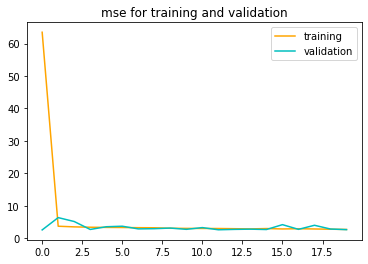

<Figure size 432x288 with 0 Axes>

In [13]:
# %%Evaluate model
loss=NN.history['loss']
vloss=NN.history['val_loss']

plt.plot(range(epoch), loss,'b', label='training', color='orange')  #b: straight line
plt.plot(range(epoch), vloss,'b', label='validation', color='c')  #b: straight line
plt.title('mse for training and validation')
plt.legend()
plt.figure()

Okay, now we need to add the moving average (MA) and standard deviation (ss) columns to the test data, but this process must be done iteratively. For the first test sample of stock i, we need to determine the moving features. After finding the moving features for each stock's first row, we can predict the target variable. Let's start by creating dataframes with train and test data for each stock so it can be easier to calculate the moving-variables from a single dataset for each stock.

The shape of each stock dataset should be (754,11); the first 713 are the train data, and the last 41 are the test data.


In [14]:
# %% creating dataframes with train and test data for each stock
for i in range(0,103):
    no="stock%d" %(i)
    condition = df["stock"] == i
    exec('{} = df[condition]'.format(no))
    no=eval(no)
    exec('{} = no.reset_index(drop = True)'.format("stock%d" %(i)))
    del no 
    
stock0.shape #train data + test data= 713 + 41 =754

(754, 11)

Now we can make predictions:

In [15]:
for j in range(0,41):  #number of rows (days) in each stock
    for i in range(0,103): #stocks           
        no="stock%d" %(i)
        no=eval(no)
        test.loc[j+i*41,'MA%d' %(nsteps_1)] = no.loc[713+j-nsteps_1:712+j,'Close'].mean()
        test.loc[j+i*41,'MA%d' %(nsteps_2)] = no.loc[713+j-nsteps_2:712+j,'Close'].mean()
        test.loc[j+i*41,'MA%d' %(nsteps_3)] = no.loc[713+j-nsteps_3:712+j,'Close'].mean()
        test.loc[j+i*41,'MA%d' %(nsteps_4)] = no.loc[713+j-nsteps_4:712+j,'Close'].mean()
        test.loc[j+i*41,'MA%d' %(nsteps_5)] = no.loc[713+j-nsteps_5:712+j,'Close'].mean()
        
        test.loc[j+i*41,'ss%d' %(nsteps_1)] = no.loc[713+j-nsteps_1:712+j,'Close'].std()
        test.loc[j+i*41,'ss%d' %(nsteps_2)] = no.loc[713+j-nsteps_2:712+j,'Close'].std()
        test.loc[j+i*41,'ss%d' %(nsteps_3)] = no.loc[713+j-nsteps_3:712+j,'Close'].std()
        test.loc[j+i*41,'ss%d' %(nsteps_4)] = no.loc[713+j-nsteps_4:712+j,'Close'].std()
        test.loc[j+i*41,'ss%d' %(nsteps_5)] = no.loc[713+j-nsteps_5:712+j,'Close'].std()
                  
    pt=np.zeros(len(test)) #array where we keep the prediction results
    q=[]  # takes the new samples to be predicted
    
    for i in range(0,103): #stocks
        q.append(test[features].iloc[j+i*41])
        
    pt=model.predict(np.array(q), verbose=1)  
                 
    for i in range(0,103): #stocks
        test.loc[j+i*41,'Close']=pt[i]  
        no="stock%d" %(i)
        no=eval(no)
        no.loc[712+j+1,'Close']=test.loc[j+i*41,'Close']
        exec('{} = no.reset_index(drop = True)'.format("stock%d" %(i)))
print("done!")            
pt=test.loc[:,"Close"] 

done!


In [16]:
# %% Visualize the predictions

preds_test_df = test.copy()
preds_test_df['Close'] = pt

def vis(STOCK_NO):
    train_fltr = train['stock'] == STOCK_NO
    train_tmp = train[train_fltr].set_index('Date')[['Close']]
    train_tmp['type'] = 'train'
    test_fltr = preds_test_df['stock'] == STOCK_NO
    test_tmp = preds_test_df[test_fltr].set_index('Date')[['Close']]
    test_tmp['type'] = 'test'
    _ = train_tmp.append(test_tmp).groupby('type')['Close'].plot(figsize=(16, 4), title = f'Stock {STOCK_NO}', sharex=False)
    _ = plt.legend()

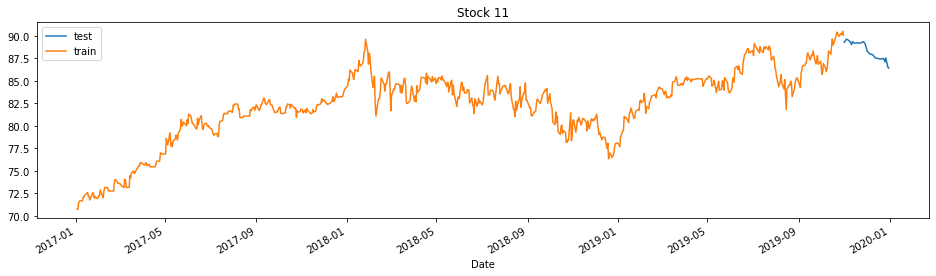

In [17]:
vis(11) #visualize prediction results for stock 11

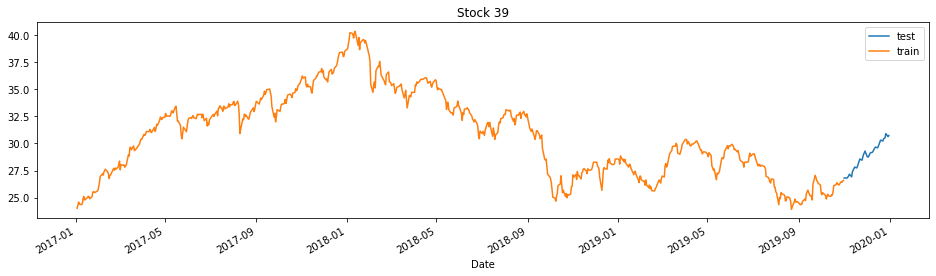

In [18]:
vis(39) #visualize prediction results for stock 39

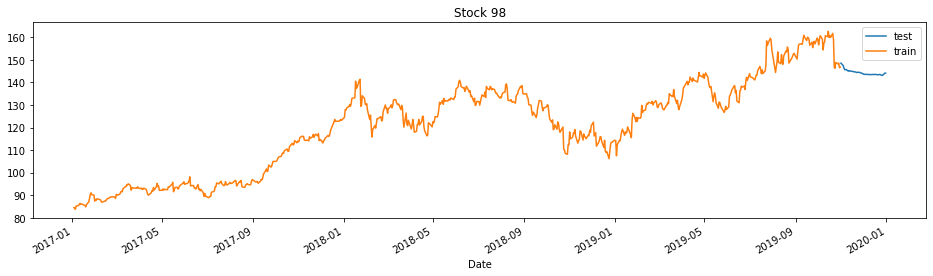

In [19]:
vis(98) #visualize prediction results for stock 98

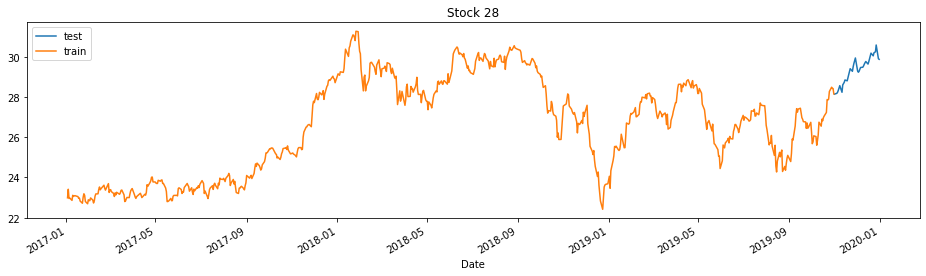

In [20]:
vis(28) #visualize prediction results for stock 28

And that's it! Hope you guys liked it! I wish I had this notebook ready until the live stream as well, but I wasn't prepared on time... Anyways, I tried to explain my approach clearly in this notebook. Please do not hesitate to ask or follow me on GitHub